# RAIGRA: Responsible AI Governance Readiness – Modelling Prototype 

This notebook documents a clean, reproducible modelling prototype behind the **Responsible AI Governance Readiness Assessment (RAIGRA)** tool.

The goal is to demonstrate how a supervised model could map structured assessment-style signals to an **AI readiness score (0–100)**.

This notebook:

1. Constructs a synthetic dataset that mimics RAIGRA-style organisational assessments.
2. Trains a baseline **RandomForestRegressor** to predict a readiness score.
3. Evaluates the model using **RMSE** and **R²**, with a single scatter plot.
4. Shows **feature importance** to interpret what drives readiness.
5. Reflects on limitations and how this would extend with real labelled data.

In [21]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

np.random.seed(42)

In [22]:
def generate_synthetic_readiness_data(n_samples: int = 600) -> pd.DataFrame:
    """
    Generate a synthetic dataset that mimics RAIGRA-style organisational assessments.

    Each row ≈ one organisation's assessment.

    Features:
    - governance_score (0–5)
    - privacy_score (0–5)
    - technical_score (0–5)
    - ethics_score (0–5)
    - org_capability_score (0–5)
    - org_size (1=small, 2=medium, 3=large)
    - sector dummies (healthcare, finance, public, education, tech, other)

    Target:
    - readiness_score (0–100), constructed with a weighted combination + noise
    """

    # Base latent scores ~ Likert-like 0–5 scale
    governance = np.random.randint(0, 6, size=n_samples)
    privacy = np.random.randint(0, 6, size=n_samples)
    technical = np.random.randint(0, 6, size=n_samples)
    ethics = np.random.randint(0, 6, size=n_samples)
    org_capability = np.random.randint(0, 6, size=n_samples)

    org_size = np.random.choice([1, 2, 3], size=n_samples, p=[0.4, 0.4, 0.2])

    sectors = np.random.choice(
        ["healthcare", "finance", "public", "education", "tech", "other"],
        size=n_samples,
        p=[0.15, 0.2, 0.2, 0.15, 0.2, 0.1],
    )

    df = pd.DataFrame(
        {
            "governance_score": governance,
            "privacy_score": privacy,
            "technical_score": technical,
            "ethics_score": ethics,
            "org_capability_score": org_capability,
            "org_size": org_size,
            "sector": sectors,
        }
    )

    # Sector-specific baselines (e.g. regulated sectors slightly higher on governance/privacy)
    sector_baseline = {
        "healthcare": 4.0,
        "finance": 3.5,
        "public": 3.2,
        "education": 3.0,
        "tech": 3.0,
        "other": 2.8,
    }

    df["sector_baseline"] = df["sector"].map(sector_baseline)

    # Construct an underlying latent readiness score (0–100)
    raw_score = (
        0.30 * df["governance_score"]
        + 0.25 * df["privacy_score"]
        + 0.20 * df["technical_score"]
        + 0.15 * df["ethics_score"]
        + 0.10 * df["org_capability_score"]
        + 0.40 * df["sector_baseline"]
    )

    readiness = (raw_score / 7.5) * 100.0
    noise = np.random.normal(loc=0.0, scale=6.0, size=n_samples)
    readiness_noisy = np.clip(readiness + noise, 0, 100)

    df["readiness_score"] = readiness_noisy.round(1)

    # One-hot encode sector (for the model)
    df = pd.get_dummies(df, columns=["sector"], drop_first=True)

    return df


df = generate_synthetic_readiness_data(600)
df.head()

,governance_score,privacy_score,technical_score,ethics_score,org_capability_score,org_size,sector_baseline,readiness_score,sector_finance,sector_healthcare,sector_other,sector_public,sector_tech
0,3,0,3,0,4,3,3.0,35.3,False,False,False,False,True
1,4,3,3,5,1,2,3.2,55.7,False,False,False,True,False
2,2,3,3,1,2,2,3.2,48.3,False,False,False,True,False
3,4,4,4,2,1,1,3.0,51.4,False,False,False,False,False
4,4,0,4,1,5,1,3.0,38.5,False,False,False,False,False


In [23]:
feature_cols = [c for c in df.columns if c != "readiness_score"]
X = df[feature_cols]
y = df["readiness_score"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

X_train.shape, X_test.shape

((450, 12), (150, 12))

RMSE: 7.023
R²:   0.726


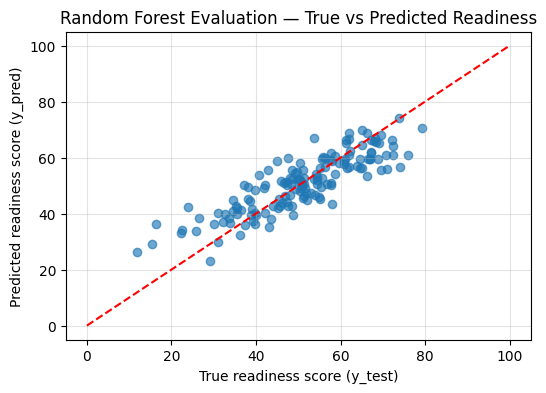

In [24]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.65)
plt.plot([0, 100], [0, 100], "r--")  # ideal line
plt.xlabel("True readiness score (y_test)")
plt.ylabel("Predicted readiness score (y_pred)")
plt.title("Random Forest Evaluation — True vs Predicted Readiness")
plt.grid(alpha=0.35)
plt.show()

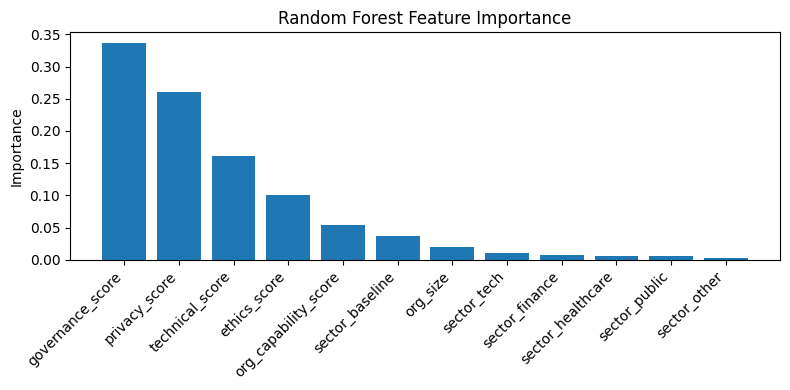

In [25]:
importances = rf.feature_importances_
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 4))
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), [feature_cols[i] for i in idx], rotation=45, ha="right")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

## Interpretation and limitations

The RandomForestRegressor in this prototype achieves:

- **RMSE ≈ 7.02 points** on a 0–100 readiness scale.
- **R² ≈ 0.726**, indicating that roughly **73% of the variance** in the readiness score can be explained by governance, privacy, technical controls, ethics, organisational capability and sector metadata.

The scatter plot shows that predictions track the diagonal reasonably well, with noise that reflects the fact that
organisational readiness is influenced by qualitative and contextual factors beyond the synthetic features.

The feature importance plot indicates that:

- Governance- and privacy-related scores are among the most influential predictors.
- Sector baseline and technical controls also contribute meaningfully.
- Organisational capability and ethics have a non-trivial but slightly lower relative contribution.

This matches the synthetic labelling design, where governance and data protection were deliberately weighted more heavily
to reflect regulatory and reputational risk.

### Limitations

- The dataset is **synthetic** and based on a hand-crafted weighting scheme, not real regulatory or audit outcomes.
- The model therefore reflects an **analytic framework**, not proven ground-truth labels.
- Hyperparameter tuning and calibration are minimal in this prototype; in a production setting, I would extend this with
  cross-validation, robustness checks and monitoring over time.

### Next steps

With real labelled assessments, this pipeline could be extended to:

1. Train on expert-scored readiness labels and regulatory findings.
2. Compare Random Forests with gradient boosting and linear baselines.
3. Use model interpretability tools (e.g. SHAP) to show organisation-specific drivers of readiness.
4. Connect the modelling workflow to the deployed RAIGRA application via a model registry and periodic evaluation reports.